# Inference and validation of the Jansen & Rit Neural Mass Model posterior

1. Posterior estimation via `sbi`-library 
2. Global validation metrics include 
    - SBC (`sbi` implementation), 
    - HPD (`lampe` implementation adapted to `sbi` posterior objects)
    - multi-PIT (ours)
    - C2ST (`sbi` implementation): only cross-val score (no hypothesis test)
    - Global L-C2ST (ours)
3. Local validation metrics include
    - Local multi-PIT (ours: marginal uniformity with method from Zhao et al.)
    - L(ocal)-C2ST (ours): cross-val score and hypothesis tests

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


import os
from pathlib import Path
from functools import partial

## SBI Task: Inference of the JR-NMM parameters under uniform prior


- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where } \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

    For simplicity, we use the notation $x$ when we actually refer to $s(x)$.

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid x_0)$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$.

### Experimental SETUP

#### Global Variables

In [2]:

# PATH
PATH_EXPERIMENT = '../saved_experiments/JR-NMM/normal_4d/'

# DATASETS
B = 50_000 # train flow
B_PRIME = 10_000 # cal set / trianing classifiers for validation diagnostics
B_DOUBLE_PRIME = 1_000 # evaluate 
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0
SINGLE_REC = False
# ground-truth gain parameter
GT_GAIN = 0

# MODEL FEATURES
NAIVE = True  # use NAIVE OR HNPE
METHOD = 'naive'*NAIVE + 'hnpe'*(1-NAIVE)

#### Meta-parameters

In [3]:
from hnpe.misc import make_label

meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [7]:
from tasks.jrnmm.simulator import prior_JRNMM, simulator_JRNMM
from tasks.jrnmm.summary import summary_JRNMM

# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0),
                                ('gain', -20.0, +20.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma', 'gain'],
                    t_recording=meta_parameters['t_recording'],
                    n_extra=N_EXTRA,
                    p_gain=prior,
                    single_recording=False)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [5]:
from tasks.jrnmm.posterior import build_flow, IdentityJRNMM, get_posterior

# posterior used for Neurips WS paper (old version of sbi...)
filename = PATH_EXPERIMENT+f'posteriors_amortized/{METHOD}_posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=True,
                                z_score_x=True,
                                n_layers=5)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0, path=PATH_EXPERIMENT+'Flows_amortized/JRNMM_nextra_00_trec_8naive_True_single_rec_False_n_layers_5/Fourier_n_rd_1_n_sr_50000_n_sf_33/'
    )
    torch.save(posterior, filename)

# Validation

### Dataset generation

In [6]:
from sbi.inference import simulate_for_sbi

# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_{METHOD}_small.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # b_theta, b_x = data_gen.get_joint_data(B)
    b_prime_theta, b_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_PRIME
    )
    b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

x_cal, theta_cal = datasets['B_prime']['x'], datasets['B_prime']['theta'] # 10_000
x_cal.shape, theta_cal.shape


(torch.Size([10000, 33, 1]), torch.Size([10000, 4]))

#### Recover order via Permutations

In [8]:

theta_new = datasets['B_prime']['theta'][:1]
print(theta_new)
for i in range(10):
    theta_new = posterior._flow._transform._transforms[1]._transforms[i]._transforms[1](theta_new)[0]
print(theta_new)

def apply_permutations(list):
    list_new = []
    permuted_ids = [2,3,1,0]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

def apply_inv_permutations(list):
    list_new = []
    permuted_ids = [3,2,0,1]
    for pi in permuted_ids:
        list_new.append(list[pi])
    return list_new

tensor([[ 104.0939,   98.6300, 3300.2747,  -18.1834]])
tensor([[3300.2747,  -18.1834,   98.6300,  104.0939]])


In [9]:
param_names = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
colors=['orange', 'red', 'purple', 'blue']

param_names_permuted = apply_permutations(param_names)
colors_permuted = apply_permutations(colors)

## Expected COVERAGE for multivariate density NPEs
We show the global PIT-distribution for the JR-NMM NPE for which correlations play an important role. We can see that there is a problem in two dimensions (the estimator is biased). We will apply the 1D local coverage test [Zhao et al.] on each dimension to get more insight on the behavior of the estimator.

### 1. PP-plots (marginal uniformity): Global PIT vs. SBC vs. HPD

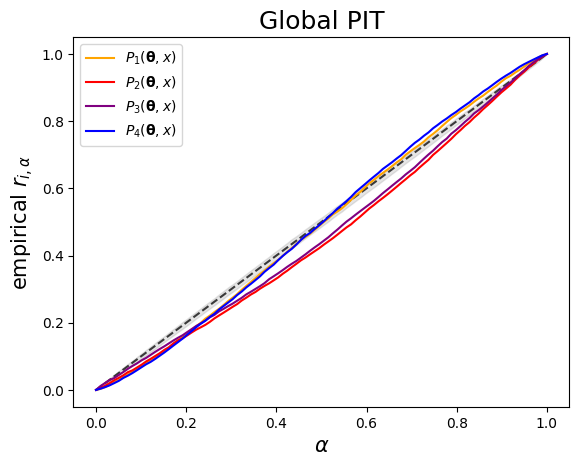

In [10]:
from valdiags.graphical_diagnostics import confidence_region_null
from valdiags.pp_plots import multi_cde_pit_values, PP_plot_1D, sbc_plot, multi_pp_plots

# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_cal, x_cal, posterior,
)
flow_joint_pit_values = [flow_joint_pit_values[i] for i in range(4)]

# flow_joint_pit_values_permuted = apply_inv_permutations(flow_joint_pit_values)

# PP-plot of expected PIT-distribution 
# r_alpha = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors=colors,
    labels=[r'$P_1(\mathbf{\theta},x)$', r'$P_2(\mathbf{\theta},x)$', r'$P_3(\mathbf{\theta},x)$', r'$P_4(\mathbf{\theta},x)$'],
    title="Global PIT",
    ylabel=r"empirical $r_{i,\alpha}$",
    confidence_int = True,
    conf_alpha=0.05/4, # bonferonni correction: global level at 0.05
)

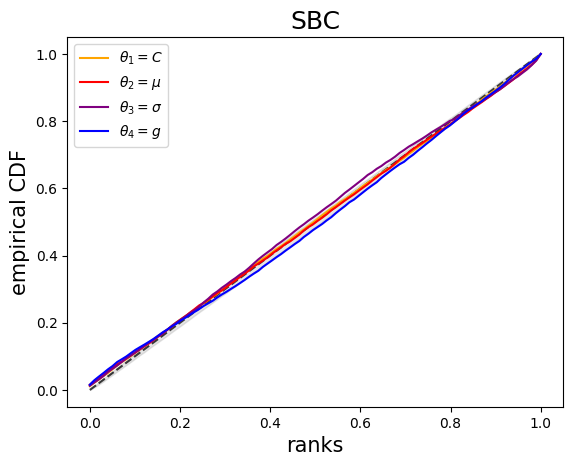

In [11]:
from sbi.analysis.sbc import run_sbc
from sbi.inference.posteriors.direct_posterior import DirectPosterior
# posterior_sbc = DirectPosterior(posterior_estimator=posterior, prior=prior,
#         x_shape=datasets['B_prime']['x'][0][None, :].shape)

# sbc = run_sbc(datasets['B_prime']['theta'], datasets['B_prime']['x'][:,None,:,:], posterior=posterior_sbc)
# torch.save(sbc, PATH_EXPERIMENT+'sbc_prime.pkl')

sbc_ranks = np.array(torch.load(PATH_EXPERIMENT+'global_tests/sbc_prime.pkl')[0])
colors=colors
labels = param_names
sbc_plot(sbc_ranks, colors=colors, labels=labels, conf_alpha=0.05/4) # bonferonni correction: global level at 0.05*4 = 0.2

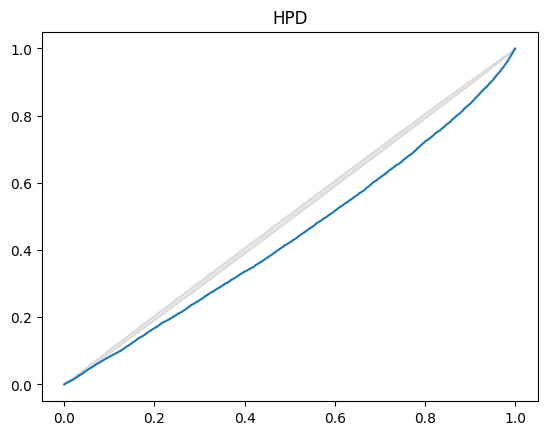

In [12]:
from valdiags.lhpd import hpd_values
from sbi.utils import match_theta_and_x_batch_shapes

def posterior_log_prob_fn(theta,x):
    theta, x = match_theta_and_x_batch_shapes(theta, x)
    return posterior.log_prob(theta,x)

if os.path.exists(PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl'):
    joint_hpd_values = torch.load(PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl')
else:
    hpd_levels = np.linspace(0.1,0.9, 11)
    joint_hpd_values = hpd_values(theta_cal, X=x_cal, est_log_prob_fn=posterior_log_prob_fn, est_sample_fn=posterior.sample)
    torch.save(joint_hpd_values, PATH_EXPERIMENT+'global_tests/hpd_ranks.pkl')

ranks = torch.cat((joint_hpd_values, torch.tensor([0.0, 1.0])))

ranks = torch.sort(ranks).values
alphas = np.linspace(0.0, 1.0, len(ranks))

confidence_region_null(alphas, N=B_PRIME, conf_alpha=0.05) # bonferonni correction
plt.plot(alphas, ranks.numpy())
plt.title("HPD")
plt.show()

### 2. Expected L-C2ST

In [13]:
import torch.distributions as D

inv_flow_samples = posterior._transform(theta_cal, context=x_cal)[0].detach()
norm_samples = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),))
norm_samples_2 = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),)) # for null hyp

joint_P_x = torch.cat([norm_samples, x_cal[:,:,0]], dim=1)
joint_Q_x = torch.cat([inv_flow_samples, x_cal[:,:,0]], dim=1)
joint_Q_x_null = torch.cat([norm_samples_2, x_cal[:,:,0]], dim=1)

In [12]:
# Expected test for l-c2st : [z_n, x_n] vs. [T(\theta_n, x_n), x_n]
from valdiags.c2st import c2st_scores

df_explc2st_jrnmm = pd.DataFrame(
    c2st_scores(P=joint_P_x, Q=joint_Q_x)[0]
)

df_explc2st_null = pd.DataFrame(
    c2st_scores(P=joint_P_x, Q=joint_Q_x_null)[0]
)

df_explc2st = pd.DataFrame({})

dfs = [pd.concat(
    [
        df.mean(axis=0).rename("mean"),
        df.std(axis=0).rename("std"),
    ], axis=1) for df in [df_explc2st_jrnmm,  df_explc2st_null]]
df_explc2st = pd.concat(dfs, keys=["jrnmm_npe", "null"])
df_explc2st.round(2)

,,mean,std
jrnmm_npe,accuracy,0.63,0.01
null,accuracy,0.50,0.01


### Neurips images

In [14]:
# colors_sbc = ['#95BF74', '#519F54', '#417448', '#31493C']
# colors_sbc = ['#FFCAD4', '#F4ACB7', '#AC5F7B', '#64113F']
colors_sbc = ['#B9D6AF', '#B2C695', '#81B598', '#519D7A']
# colors_pit = ['#3BCEAC','#FFD23F','#EE4266','#540D6E']
colors_pit = ['#C095EE','#FFD23F','#EE4266','#540D6E']

labels_sbc = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$', r'$\theta_4 = g$']
labels_pit = [r'$P_{1}(\mathbf{\theta})$', r'$P_{2}(\mathbf{\theta})$', r'$P_{3}(\mathbf{\theta})$', r'$P_{4}(\mathbf{\theta})$']

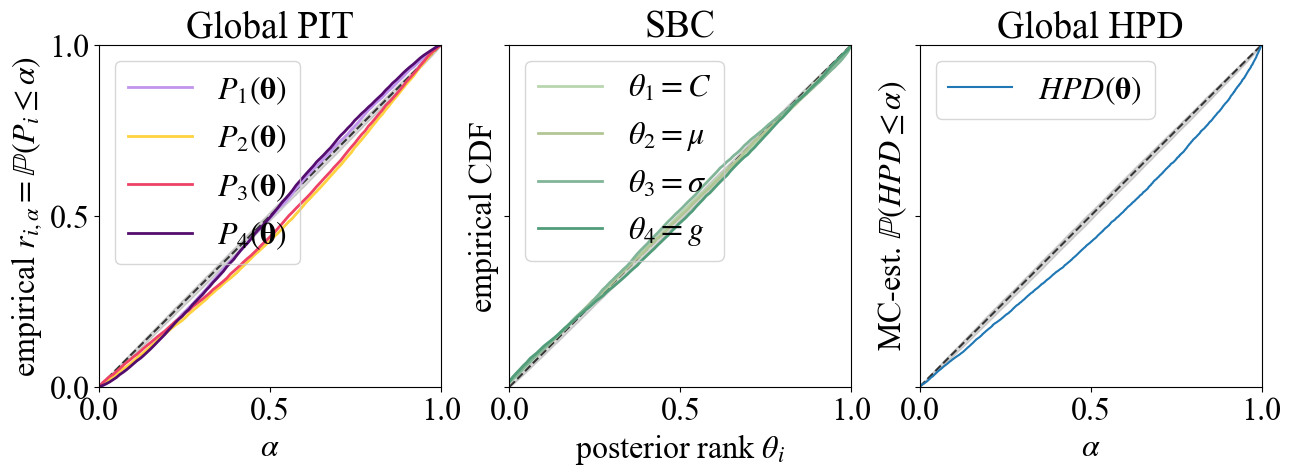

In [16]:
from plots_multiPIT_neurips2022 import multi_global_consistency

fig = multi_global_consistency(multi_PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors_sbc=colors_sbc,
    colors_pit=colors_pit,
    labels_sbc=labels_sbc,
    labels_pit = labels_pit,
    sbc_ranks=sbc_ranks,
    hpd_values=joint_hpd_values
    )


# plt.savefig(PATH_EXPERIMENT+'images_neurips/global_consistency.pdf')

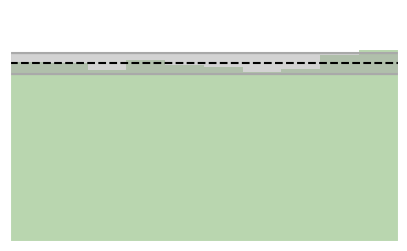

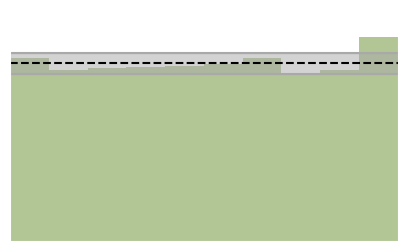

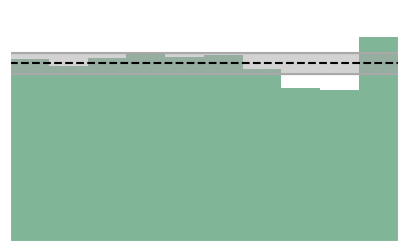

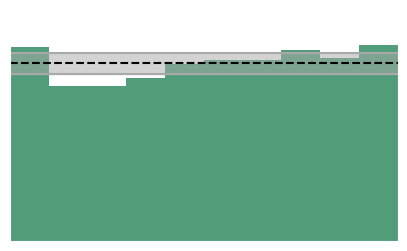

In [17]:
from plots_multiPIT_neurips2022 import global_histograms
for i in range(4):
    fig = global_histograms(sbc_ranks[:,i]/1000, color=colors_sbc[i], conf_alpha=0.05) # bonferonni correction: global level at 0.05*4 = 0.2
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_SBC_dim{i}.pdf')
    plt.show()

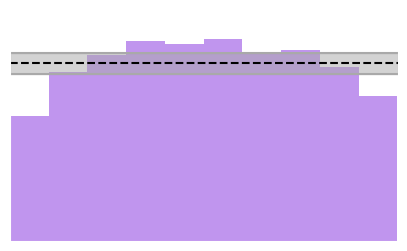

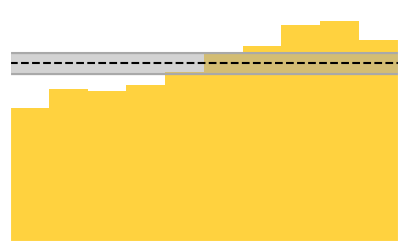

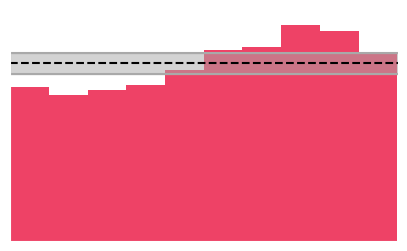

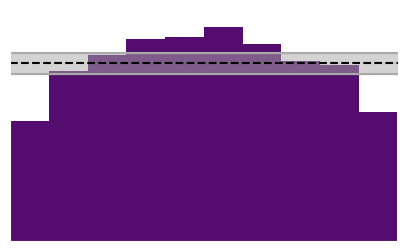

In [18]:
for i in range(4):
    fig = global_histograms(flow_joint_pit_values[i], color=colors_pit[i], conf_alpha=0.05) # bonferonni correction: global level at 0.05*4 = 0.2
    plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalPIT_dim{i}.pdf')
    plt.show()

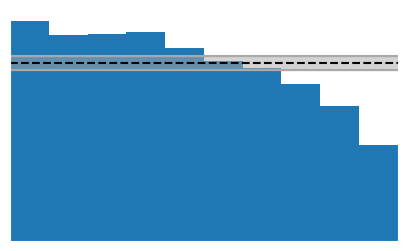

In [20]:
fig = global_histograms(np.array(joint_hpd_values).ravel(), color='#1f77b4', conf_alpha=0.05*4) # bonferonni correction: global level at 0.05*4 = 0.2
plt.savefig(PATH_EXPERIMENT+f'images_neurips/hist_globalHPD.pdf')
plt.show()

## LOCAL COVERAGE:

### Ground-truth parameters and observations for evaluation

We know that the parameters $(\mu, \sigma)$ and $g$ are coupled.

We thus choose to analyse the behavior of the estimator on a 1D cut through the parameter space, i.e. at different $x_0 = \text{Simulator}(C_0, \mu_0, \sigma_0, g_0)$ where $C_0, \mu_0, \sigma_0$ are fixed and we only vary the gain parameter $g_0 \in [-20,20]$.

**Intuition:** The average gain value is $\sum_{g=-20}^{20} g = 0$. We expect a consistent estimator at $g_0 = 0$, as the estimator is trained to maximize the ***average*** log-likelihood. If this is true, we would expect inconsistent behavior at $g_0 \neq 0$, because the estimator is globally biased for $(\mu, \sigma)$.

In [21]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-25,25,11)

# theta_true_list = []

# x_obs_list = []
# for g in gain_list:
#     theta_true = torch.FloatTensor([c, mu, sigma, g])
#     meta_parameters['theta'] = theta_true
#     theta_true_list.append(theta_true)

#     ground_truth = get_ground_truth(meta_parameters,
#                                 input_parameters=['C', 'mu', 'sigma', 'gain'],
#                                 p_gain=prior, single_recording=SINGLE_REC)
#     ground_truth['observation'] = summary_extractor(ground_truth['observation'])
#     x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
#     x_obs_list.append(x_obs)
# # torch.save([theta_true, torch.stack(x_obs_list)[:,0,:,:]], PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')

x_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations/nextra_0/gain_experiment_new.pkl')[1]
x_obs_list.shape


torch.Size([11, 33, 1])

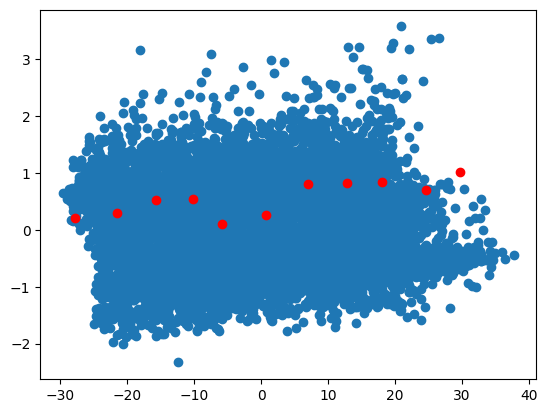

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cal[:,:,0]) 
x_new = pca.transform(x_cal[:,:,0])

mpl.rcParams.update(mpl.rcParamsDefault)
plt.scatter(x_new[:,0],x_new[:,1])
x_new_obs = pca.transform(x_obs_list[:,:,0])
plt.scatter(x_new_obs[:,0],x_new_obs[:,1], color='red')
plt.show()

### 1. Local PIT: marginal uniformity

In [23]:
from valdiags.multiPIT import get_lct_results

path_lct = PATH_EXPERIMENT + f"lct_results/naive_nextra_{N_EXTRA}_nsim_{B}/gain/"

path_lct_base_t1000_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{100}_n_alphas_{100}"
)  # no pvalues, used to compute Test statistic and pp-pplot

gain_list = np.linspace(-20, 20, 9, dtype=int)

lct_base_t1000_na100_path_list = []

for g in gain_list:
    lct_base_t1000_na100_path_list.append(path_lct_base_t1000_na100 + f"_gain_{g}.pkl")


df_base_na100 = get_lct_results(lct_base_t1000_na100_path_list, pvalues=False)
df_base_na100.index = gain_list

#### PP-plots

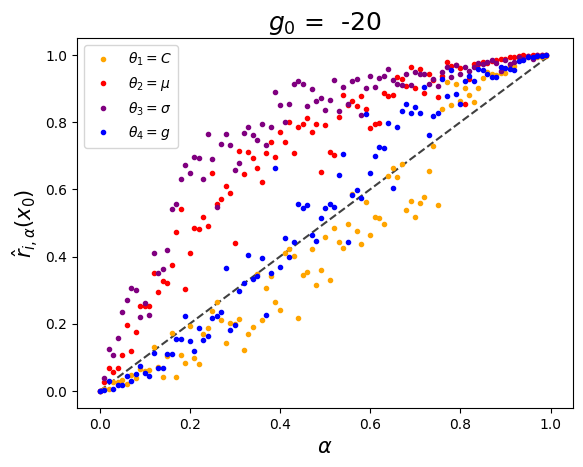

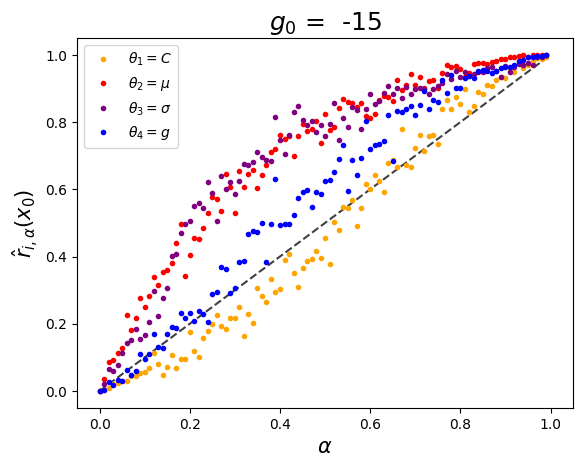

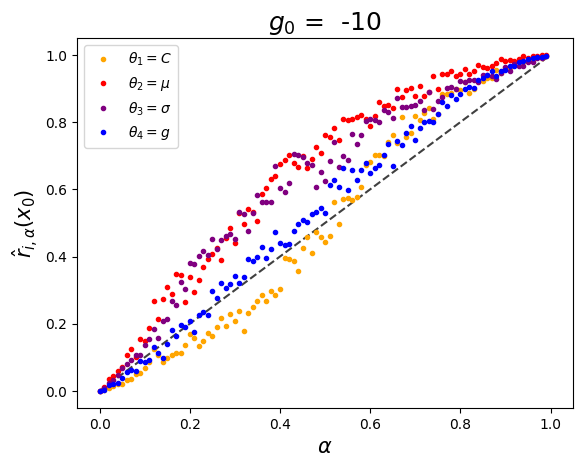

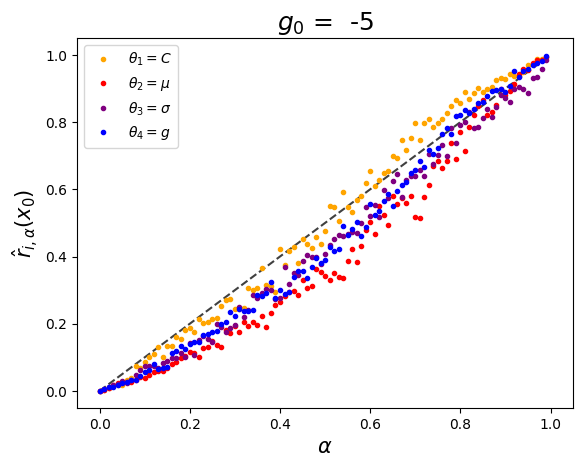

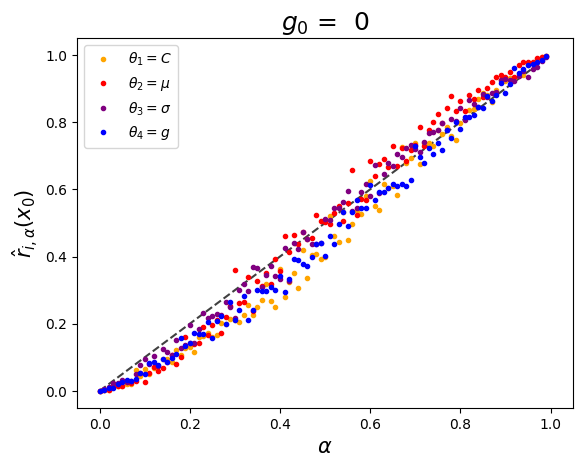

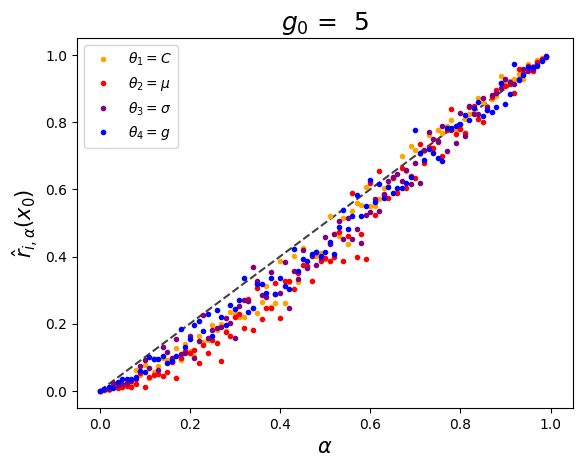

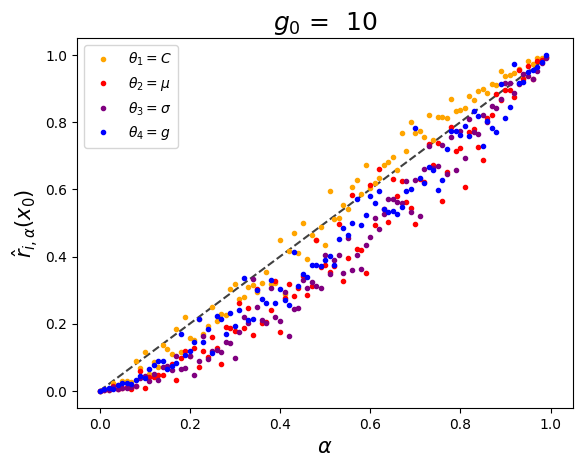

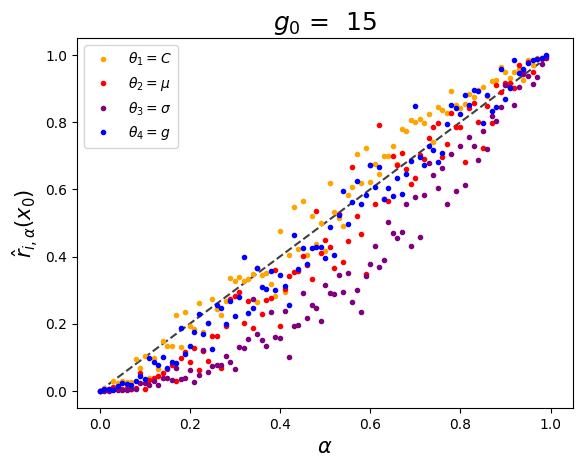

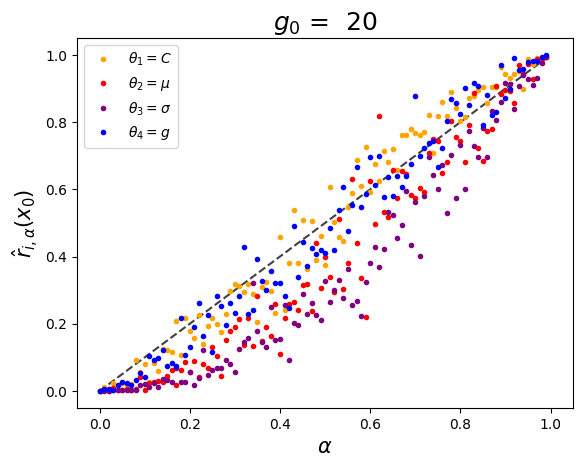

In [24]:
# pp-plots for accepted x_0
# from diagnostics.pp_plots import multi_pp_plots
mpl.rcParams.update(mpl.rcParamsDefault)
x_eval_names = [r"$g_0$ = " + f" {g}" for g in gain_list]
param_names = [r"$\theta_1=C$ ", r"$\theta_2=\mu$ ", r"$\theta_3=\sigma$ ", r"$\theta_4=g$ "]
multi_pp_plots(
    [
        # [
        #     lct_base_t1000_na100_path_list[0],
        #     lct_base_t1000_na100_path_list[4],
        #     lct_base_t1000_na100_path_list[8],
        # ]
        lct_base_t1000_na100_path_list
    ],
    x_eval_names,
    param_names,
    pvalues=False,
    title="",
    ylabel=r"$\hat{r}_{i,\alpha}(x_0)$"
)



#### Test Statistic 

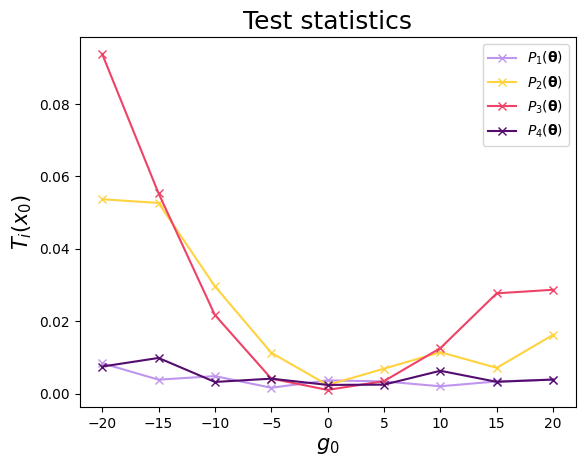

In [25]:
mpl.rcParams.update(mpl.rcParamsDefault)
# T_permuted = apply_inv_permutations([df_base_na100[f'dim_{i}'] for i in range(1,5)])
id = list(range(4))
iperm = apply_inv_permutations(id)
for i,ip in zip(id,iperm):
    plt.plot(gain_list, df_base_na100[f'dim_{i+1}'], marker='x', color=colors_pit[i],label=labels_pit[i])

plt.xlabel(r'$g_0$', fontsize=15)
plt.ylabel(r'$T_{i}(x_0)$', fontsize=15)
plt.title(r'Test statistics', fontsize=18)
plt.legend()
plt.show()

#### Null hypothesis and p-values

In [26]:
n_trials=100
path_lct_base_t100_na100 = (
    path_lct + f"baseline/lct_results_baseline_mlp_nalpha_100_ntrials_{n_trials}_n_alphas_{100}"
) 

gain_list_new = [-20,0,20]

r_alpha_null_list = []
for g in gain_list_new:
    dict_null = torch.load(path_lct_base_t100_na100 + f"_gain_{g}.pkl")
    r_alpha_null = {}
    for k in range(n_trials):
        r_alpha_null[k] = pd.Series(dict_null['r_alpha_null_list'][k]['dim_1'])
    r_alpha_null_list.append(r_alpha_null)

In [27]:
df = get_lct_results(lct_base_t1000_na100_path_list)
df.loc[:, df.columns.str.contains('p_values')]

,p_values__dim_1,p_values__dim_2,p_values__dim_3,p_values__dim_4,p_values__hmean
0,0.00,0.0,0.00,0.01,0.0
1,0.00,0.0,0.00,0.00,0.0
2,0.00,0.0,0.00,0.00,0.0
3,0.03,0.0,0.00,0.00,0.0
4,0.00,0.0,0.12,0.00,0.0
5,0.00,0.0,0.00,0.00,0.0
6,0.10,0.0,0.00,0.00,0.0
7,0.00,0.0,0.00,0.02,0.0
8,0.15,0.0,0.00,0.12,0.0


### 2. Local HPD


#### Pre-train L-HPD

In [29]:
joint_hpd_values.shape

torch.Size([10002])

In [31]:
from valdiags.lhpd import lhpd_scores, t_stats_lhpd
from sbi.utils import match_theta_and_x_batch_shapes

def posterior_log_prob_fn(theta, x):
    theta, x = match_theta_and_x_batch_shapes(theta, x)
    return posterior._log_prob(theta, x)

n_alphas = 11

_,_, trained_clfs_lhpd = lhpd_scores(
    Y=theta_cal,
    X=x_cal[:,:,0],
    n_alphas=n_alphas,
    joint_hpd_values=joint_hpd_values[1:-1],
    est_log_prob_fn=None,
    est_sample_fn=None,
    x_eval=None,
    eval=False,
    # same as in zhao et al 
    clf_kwargs={"alpha":0, "max_iter": 25000}, 
)

Training L-HPD: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]


#### Evaluate for every x_0


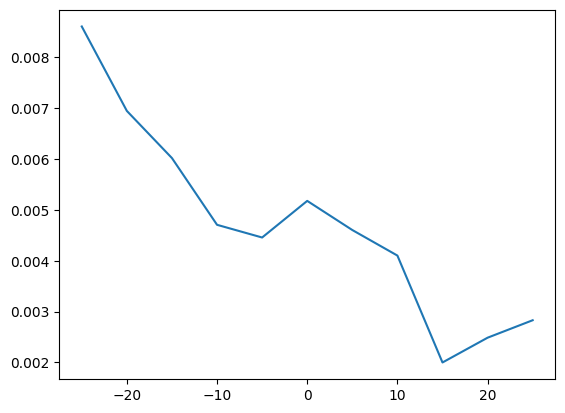

In [32]:
gain_list = np.linspace(-25,25,11, dtype=int)
t_stat_obs_lhpd = {}
r_alphas_obs = {}
for x_obs, g in zip(x_obs_list[:,:,0], gain_list):
    t_stat_obs_lhpd[g], r_alphas_obs[g] = t_stats_lhpd(
        x_eval = x_obs[None,:],
        n_alphas=n_alphas,
        trained_clfs=trained_clfs_lhpd,
        est_log_prob_fn=None,
        est_sample_fn=None,
        Y=None,
        X=None,
        return_r_alphas = True,
    )
    t_stat_obs_lhpd[g] = t_stat_obs_lhpd[g]["mse"]

plt.plot(gain_list, list(t_stat_obs_lhpd.values()))
plt.show()

#### Compute T under the null

In [33]:
_, _, trained_clfs_null_lhpd = t_stats_lhpd(
    null_hypothesis=True,
    n_trials_null=10,
    Y=theta_cal,
    X=x_cal[:,:,0],
    n_alphas=n_alphas,
    return_clfs_null=True,
    x_eval=None,
    est_log_prob_fn=None,
    est_sample_fn=None,
    eval=False,
    clf_kwargs = {"alpha":0, "max_iter": 25000},
)

Training / Computing T under (H0): 100%|██████████| 10/10 [01:54<00:00, 11.48s/it]


In [34]:
gain_list = np.linspace(-25,25,11, dtype=int)
t_stats_null_obs_lhpd = {}
r_alphas_null_obs = {}
for x_obs, g in zip(x_obs_list[:,:,0], gain_list):
    t_stats_null_obs_lhpd[g], r_alphas_null_obs[g] = t_stats_lhpd(
        null_hypothesis=True,
        n_trials_null=10,
        trained_clfs_null=trained_clfs_null_lhpd,
        x_eval = x_obs[None,:],
        n_alphas=n_alphas,
        est_log_prob_fn=None,
        est_sample_fn=None,
        Y=theta_cal,
        X=None,
        return_r_alphas = True,
    )
    t_stats_null_obs_lhpd[g] = t_stats_null_obs_lhpd[g]["mse"]

Training / Computing T under (H0): 100%|██████████| 10/10 [00:00<00:00, 540.13it/s]


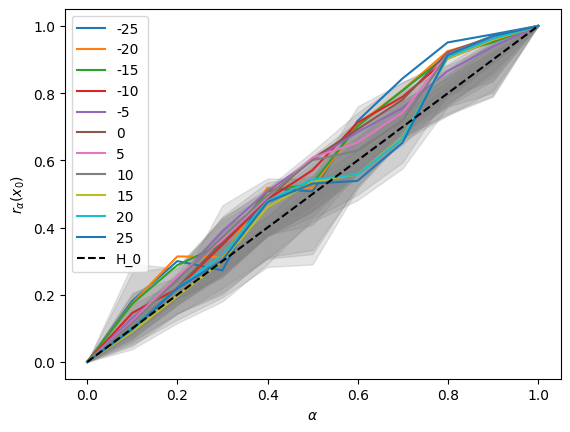

In [35]:

for g in gain_list:
    r_alphas_obs[g] = {**r_alphas_obs[g], **{1.0: 1.0}}
    plt.plot(r_alphas_obs[g].keys(), r_alphas_obs[g].values(), label=str(g))
    
    r_alphas_null_obs[g] = {**r_alphas_null_obs[g], **{(n_alphas+1): [1.0] * 10}}
    alphas = np.concatenate([np.linspace(0,0.999,n_alphas), [1]])
    lower_band = pd.DataFrame(r_alphas_null_obs[g]).quantile(q=0.05 / 2, axis=0)
    upper_band = pd.DataFrame(r_alphas_null_obs[g]).quantile(q=1 - 0.05 / 2, axis=0)
    plt.fill_between(alphas, lower_band, upper_band, color="grey", alpha=0.2)
plt.plot(r_alphas_obs[g].keys(), r_alphas_obs[g].keys(), '--', color='black', label='H_0')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$r_{\alpha}(x_0)}$')
plt.legend()
plt.show()

### 3. Local C2ST 


#### Data

In [36]:
import torch.distributions as D

n_cal = len(x_cal)
n_eval = 10_000

inv_flow_samples_cal = posterior._transform(theta_cal, context=x_cal)[0].detach()
base_dist_samples_cal = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((n_cal,))
base_dist_samples_eval = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((n_eval,))

#### Pretrain L-C2ST

In [37]:
from valdiags.lc2st import lc2st_scores, t_stats_lc2st, sbibm_clf_kwargs

sbibm_kwargs = sbibm_clf_kwargs(4)

lc2st_scores_kwargs = {"cross_val":False, "clf_kwargs":sbibm_kwargs}

_,_, trained_clfs = lc2st_scores(
    P=base_dist_samples_cal,
    Q=inv_flow_samples_cal,
    x_P=x_cal[:,:,0],
    x_Q=x_cal[:,:,0],
    x_eval=None,
    eval=False,
    return_clfs=True,
    **lc2st_scores_kwargs
)

#### Eval for every x_0

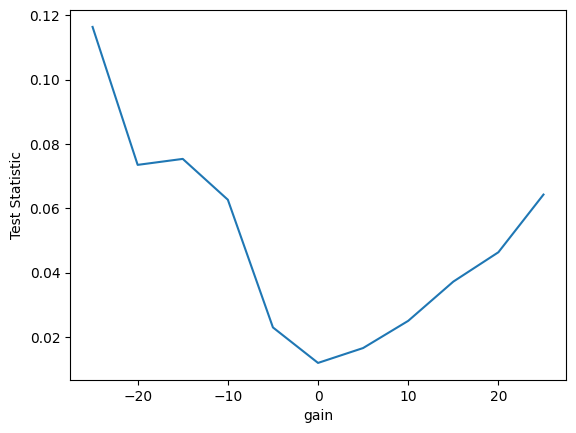

In [38]:
gain_list = np.linspace(-25,25,11, dtype=int)
t_stat_obs = {}
probas_obs = {}

for x_obs, g in zip(x_obs_list[:,:,0], gain_list):
    t_stat_obs[g], probas_obs[g] = t_stats_lc2st(
        x_eval = x_obs[None,:],
        P_eval=base_dist_samples_eval,
        trained_clfs=trained_clfs,
        P=None,
        Q=None,
        x_P=None,
        x_Q=None,
        **lc2st_scores_kwargs
    )
    t_stat_obs[g] = t_stat_obs[g]["mse"]

plt.plot(gain_list, list(t_stat_obs.values()))
plt.xlabel("gain")
plt.ylabel("Test Statistic")
plt.show()

#### Compute T under the null

In [39]:
list_P_null = [D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((n_cal,))]*200
list_P_eval_null = [D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((n_eval,))]*200
_, _, trained_clfs_null = t_stats_lc2st(
    null_hypothesis=True,
    use_permutation=False,
    list_P_null=list_P_null,
    list_P_eval_null=list_P_eval_null,
    list_x_P_null = [x_cal[:,:,0]]*200,
    n_trials_null=100,
    P=None,
    Q=None,
    x_P=None,
    x_Q=None,
    P_eval=None,
    x_eval=None,
    eval=False,
    return_clfs_null=True,
    **lc2st_scores_kwargs
)

Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [06:57<00:00,  4.17s/it]


In [40]:
gain_list = np.linspace(-25,25,11, dtype=int)
t_stat_obs_null = {}
probas_obs_null = {}

for x_obs, g in zip(x_obs_list[:,:,0], gain_list):
    t_stat_obs_null[g], probas_obs_null[g] = t_stats_lc2st(
        null_hypothesis=True,
        trained_clfs_null=trained_clfs_null,
        use_permutation=False,
        x_eval = x_obs[None,:],
        list_P_eval_null=list_P_eval_null,
        list_P_null=list_P_null,
        list_x_P_null=[x_cal[:,:,0]]*200,
        P=None,
        Q=None,
        x_P=None,
        x_Q=None,
        P_eval=None,
        **lc2st_scores_kwargs 
    )
    t_stat_obs_null[g] = t_stat_obs_null[g]["mse"]


Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:00<00:00, 102.87it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 99.11it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 99.20it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 95.39it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 98.52it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:00<00:00, 101.15it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 99.04it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:00<00:00, 100.73it/s]
Training / Computing T under (H0) - permutation = False: 100%|██████████| 100/100 [00:01<00:00, 96.79it/s]
Training / Computing T under (H0) 

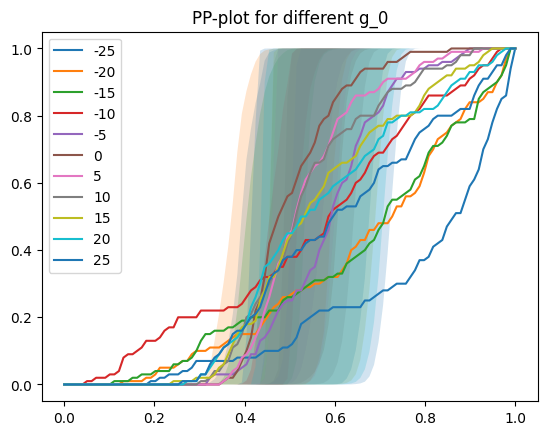

In [43]:
# Plot PP-plots and compute test-statistics/p-values
from valdiags.graphical_diagnostics import PP_vals
from valdiags.test_utils import compute_pvalue

plt.rcParams.update(plt.rcParamsDefault)

p_value = {}
reject = {}


for g in gain_list:

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*10000, alphas)

    # nb samples = 10000
    # plt.plot(alphas, pp_vals_dirac, '--', color='black')

    pp_vals_null = {}
    for t in range(len(probas_obs_null[g])):
        pp_vals_null[t] = pd.Series(PP_vals(probas_obs_null[g][t], alphas))
    
    pp_vals = {}
    for t in range(100):
        pp_vals[t] = pd.Series(PP_vals(probas_obs[g][t], alphas))

    low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
    up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
    plt.fill_between(alphas, low_null, up_null, alpha=0.2) #, label='95% confidence region', color="grey", alpha=0.3)

    low = pd.DataFrame(pp_vals).quantile(0.05/2, axis=1)
    up = pd.DataFrame(pp_vals).quantile(1-0.05/2, axis=1)
    line = pd.DataFrame(pp_vals).mean(axis=1)
    plt.plot(alphas, line, label=f'{g}')
    plt.legend()
    # plt.title(f'PP-plot for g_0 = {g}')
    # plt.show()


    p_value[g] = sum(1 * (t_stat_obs[g] < pd.Series(t_stat_obs_null[g]))) / len(t_stat_obs_null[g])

    # print('test stat: ', t_stat_obs[g])
    # print('p-value: ', p_value[g])
    if p_value[g] <= 0.05:
    #     print('rejected')
        reject[g] = True
    else:
    #     print('not rejected')
        reject[g] = False

plt.title(f'PP-plot for different g_0')
plt.legend()
plt.show()

In [44]:
# Show test results in dataframe
df_results = {}
df_results = pd.DataFrame({
    'test_stat': t_stat_obs, 
    'p_value': p_value, 
    'rejected': reject 
})
df_results

,test_stat,p_value,rejected
-25,0.116417,0.00,True
-20,0.073553,0.00,True
-15,0.075411,0.00,True
-10,0.062722,0.00,True
-5,0.023045,0.00,True
0,0.012019,0.01,True
5,0.016643,0.00,True
10,0.025090,0.01,True
15,0.037277,0.03,True
20,0.046405,0.02,True


### Neurips images


/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This wil

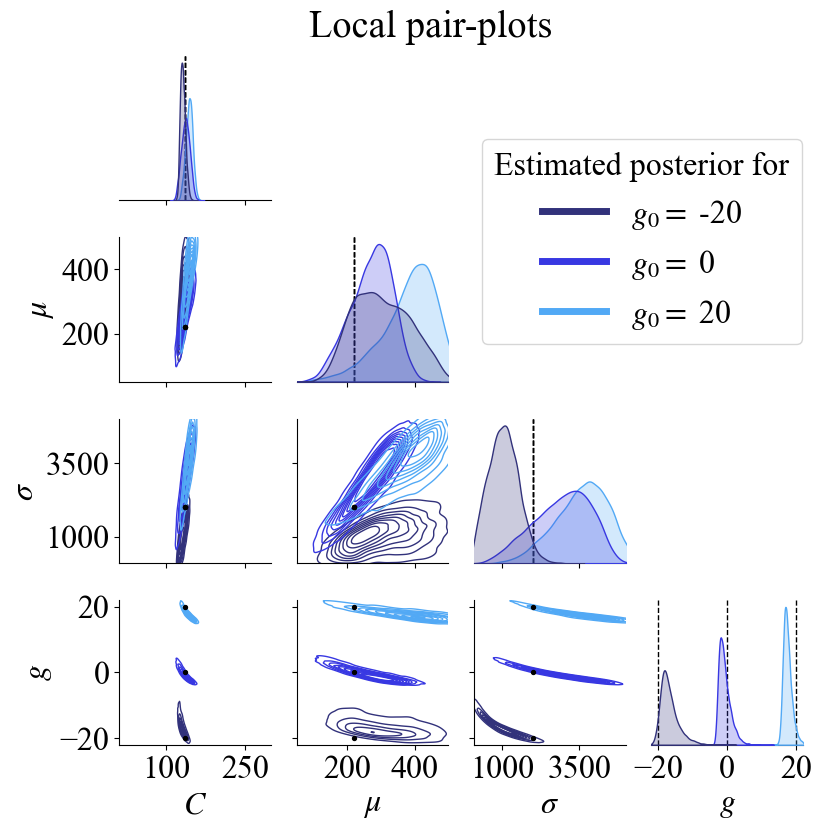

In [50]:
from plots_multiPIT_neurips2022 import plot_pairgrid_with_groundtruth

# Plot learned posteriors with true parameters 
cases = [{'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -20, 'xobs_id': 1, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': -15, 'xobs_id': 2, 'n_sim': B,'single_rec': SINGLE_REC},
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 0, 'xobs_id': 5, 'n_sim': B,'single_rec': SINGLE_REC},
    # {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 15, 'xobs_id': 8, 'n_sim': B,'single_rec': SINGLE_REC},]
    {'method': METHOD, 'n_extra': N_EXTRA, 'gt_gain': 20, 'xobs_id': 9, 'n_sim': B,'single_rec': SINGLE_REC},]

posteriors = {}
context = {}
theta_true_list = []
for exp in cases:
    # filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    # filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}_new.pkl"
    if exp['n_extra'] > 0:
        filename_xobs = filename[:-4]+f"_single_rec_{exp['single_rec']}.pkl"
    
    label = r"$g_0 =$"+f" {exp['gt_gain']}"
    posteriors[label]= posterior #torch.load(filename_posterior)
    # context[label] = torch.load(filename_xobs)
    context[label] = x_obs_list[exp['xobs_id']][None,:,:]
    theta_true_list.append(np.array([c, mu, sigma, exp['gt_gain']])) 

color_dict = dict(zip(list(posteriors.keys()), ['#32327B', '#3838E2', '#52A9F5']))
# color_dict = dict(zip(list(posteriors.keys()), ['blue','purple', '#D90368', '#FFA500','gold']))

g = plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=theta_true_list,
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Estimated posterior for'
)

g.savefig(PATH_EXPERIMENT+'images_neurips/parigrid.pdf')
plt.show()

/var/folders/56/162hrf1x5hg70vm0swrrv1_80000gn/T/ipykernel_31624/755534086.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/var/folders/56/162hrf1x5hg70vm0swrrv1_80000gn/T/ipykernel_31624/755534086.py:4: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
/opt/miniconda3/envs/sbibm_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


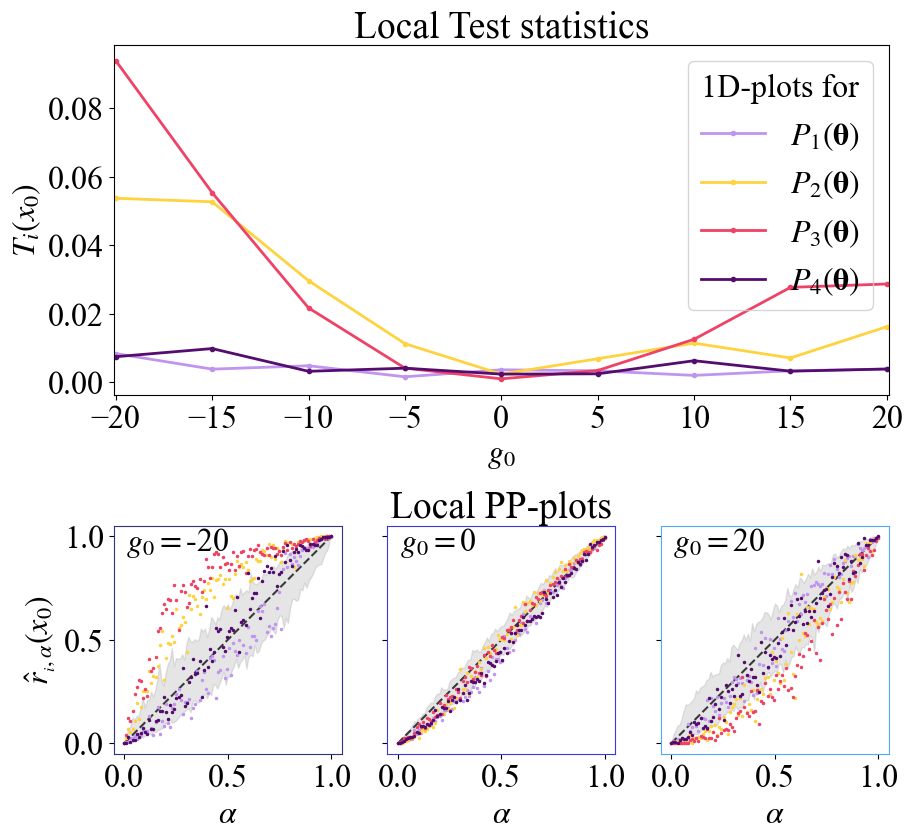

In [51]:
from plots_multiPIT_neurips2022 import multi_local_consistency
colors = []
fig = multi_local_consistency(lct_base_t1000_na100_path_list, gain_list[1:-1], colors_pit, labels_pit, r_alpha_null_list=r_alpha_null_list, conf_alpha=0.05/4) # bonferonni correction
plt.savefig(PATH_EXPERIMENT+'images_neurips/local_consistency.pdf')
plt.show()